In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import DataLoader, Subset, Sampler
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import torch.optim as optim
import torch.nn as nn
from torchvision.models import efficientnet_b1

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512, 128)  # Adjusted for Global Average Pooling
        self.dropout = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = self.pool5(torch.relu(self.bn5(self.conv5(x))))
        x = torch.nn.functional.adaptive_avg_pool2d(x, (1, 1))  # Global Average Pooling
        x = torch.flatten(x, 1)  # Flatten to (batch_size, num_features)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)  # No sigmoid for BCEWithLogitsLoss
        return x



In [3]:
model = CNNModel().to("cuda")

# ================================
# 1. Define Transforms
# ================================

from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to 640x640
    transforms.ToTensor(),                  # Convert image to Tensor
])




# For Validation
val_transforms = transforms.Compose([
    transforms.Resize((640, 640)),  # Resize to 640x640
    transforms.ToTensor(),  # Convert image to Tensor

])

# ================================
# 2. Load Dataset and Split
# ================================

data_dir = '/content/drive/MyDrive/dataset_Eff_2/dataset_Eff_2'  # Replace with your data directory

# Load the full dataset with training transforms
dataset = ImageFolder(root=data_dir, transform=train_transforms)

# Get labels
labels = np.array([label for _, label in dataset.samples])

# Stratified split into training and validation sets (75% train, 25% val)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=0)
train_indices, val_indices = next(split.split(np.zeros(len(labels)), labels))


train_dataset = Subset(ImageFolder(root=data_dir, transform=train_transforms), train_indices)
val_dataset = Subset(ImageFolder(root=data_dir, transform=val_transforms), val_indices)


# Apply validation transforms to the validation subset
val_dataset.dataset.transform = val_transforms


# ================================
# 3. Initialize Sampler and DataLoader
# ================================

# Extract labels for the training subset
train_labels = labels[train_indices]

# Get class0 and class1 indices relative to the training subset
class0_indices = np.where(train_labels == 0)[0].tolist()
class1_indices = np.where(train_labels == 1)[0].tolist()

# Create the DataLoader for training with the custom sampler
train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    pin_memory=True,
    num_workers=4,
    drop_last=True
)

# Create the DataLoader for validation (no sampler needed)
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

# ================================
# 4. Training Loop
# ================================

criterion = nn.BCEWithLogitsLoss().to("cuda")
optimizer = optim.AdamW(model.parameters(), lr=0.00005)


num_epochs = 30  # Number of training epochs
best_val_f1 = -1.0  # To track the best validation F1 score
patience = 5  # Early stopping patience
trigger_times = 0  # Counter for early stopping

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()

# Cosine Annealing Scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')


# Initialize lists to store loss and accuracy values for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}')

    # ================================
    # 5.1 Training Phase
    # ================================
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels_batch in tqdm(train_loader, desc="Training"):
        inputs = inputs.to('cuda', non_blocking=True)
        labels_batch = labels_batch.to('cuda', non_blocking=True).float()

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels_batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Sigmoid and threshold for accuracy
        preds = torch.sigmoid(outputs).round()
        correct_predictions += (preds == labels_batch).sum().item()
        total_predictions += labels_batch.size(0)

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(epoch_loss)  # Store training loss for plotting
    train_accuracies.append(train_accuracy)  # Store training accuracy for plotting
    print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}')

    # ================================
    # 5.2 Validation Phase
    # ================================
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels_batch in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to('cuda', non_blocking=True)
            labels_batch = labels_batch.to('cuda', non_blocking=True).float()

            with torch.cuda.amp.autocast():
                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels_batch)

            val_loss += loss.item()

            # Sigmoid and threshold for accuracy
            preds = torch.sigmoid(outputs).round()
            correct_predictions += (preds == labels_batch).sum().item()
            total_predictions += labels_batch.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())

    val_loss /= len(val_loader)
    val_accuracy = correct_predictions / total_predictions
    val_losses.append(val_loss)  # Store validation loss for plotting
    val_accuracies.append(val_accuracy)  # Store validation accuracy for plotting
    val_f1 = accuracy_score(all_labels, all_preds)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1: {val_f1:.4f}')

    # ================================
    # 5.3 Scheduler Step
    # ================================
    scheduler.step()

    # ================================
    # 5.4 Early Stopping and Model Saving
    # ================================
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_CNNScratch.pth')
        print("Best model saved.")
        trigger_times = 0
    else:
        trigger_times += 1
        print(f'No improvement in validation Accuracy for {trigger_times} epoch(s).')

    if trigger_times >= patience:
        print(f'Early stopping triggered after {patience} epochs without improvement.')
        break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()



Epoch 1/30

Epoch 2/30

Epoch 3/30

Epoch 4/30

Epoch 5/30

Epoch 6/30

Epoch 7/30

Epoch 8/30

Epoch 9/30

Epoch 10/30

Epoch 11/30

Epoch 12/30

Epoch 13/30

Epoch 14/30

Epoch 15/30

Epoch 16/30

Epoch 17/30

Epoch 18/30

Epoch 19/30

Epoch 20/30

Epoch 21/30

Epoch 22/30

Epoch 23/30

Epoch 24/30

Epoch 25/30

Epoch 26/30

Epoch 27/30

Epoch 28/30

Epoch 29/30

Epoch 30/30

Epoch 1/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [01:04<00:00,  2.27it/s]


Training Loss: 0.6518, Training Accuracy: 0.6086


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:13<00:00,  2.78it/s]


Validation Loss: 0.6342, Validation Accuracy: 0.6460, Validation F1: 0.6460
Best model saved.

Epoch 2/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:31<00:00,  4.57it/s]


Training Loss: 0.5703, Training Accuracy: 0.7155


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:08<00:00,  4.44it/s]


Validation Loss: 0.5619, Validation Accuracy: 0.7526, Validation F1: 0.7526
Best model saved.

Epoch 3/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:37<00:00,  3.83it/s]


Training Loss: 0.5172, Training Accuracy: 0.7595


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:13<00:00,  2.79it/s]


Validation Loss: 0.5244, Validation Accuracy: 0.7766, Validation F1: 0.7766
Best model saved.

Epoch 4/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:44<00:00,  3.28it/s]


Training Loss: 0.4752, Training Accuracy: 0.7974


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:12<00:00,  2.92it/s]


Validation Loss: 0.5053, Validation Accuracy: 0.7835, Validation F1: 0.7835
Best model saved.

Epoch 5/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:41<00:00,  3.46it/s]


Training Loss: 0.4373, Training Accuracy: 0.8172


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:10<00:00,  3.44it/s]


Validation Loss: 0.4635, Validation Accuracy: 0.8007, Validation F1: 0.8007
Best model saved.

Epoch 6/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:33<00:00,  4.31it/s]


Training Loss: 0.3983, Training Accuracy: 0.8457


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.77it/s]


Validation Loss: 0.5155, Validation Accuracy: 0.7732, Validation F1: 0.7732
No improvement in validation Accuracy for 1 epoch(s).

Epoch 7/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:33<00:00,  4.38it/s]


Training Loss: 0.3679, Training Accuracy: 0.8560


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:07<00:00,  4.90it/s]


Validation Loss: 0.3836, Validation Accuracy: 0.8419, Validation F1: 0.8419
Best model saved.

Epoch 8/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:37<00:00,  3.86it/s]


Training Loss: 0.3467, Training Accuracy: 0.8672


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:12<00:00,  3.01it/s]


Validation Loss: 0.3646, Validation Accuracy: 0.8660, Validation F1: 0.8660
Best model saved.

Epoch 9/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:34<00:00,  4.20it/s]


Training Loss: 0.3196, Training Accuracy: 0.8767


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.63it/s]


Validation Loss: 0.3377, Validation Accuracy: 0.8729, Validation F1: 0.8729
Best model saved.

Epoch 10/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:34<00:00,  4.21it/s]


Training Loss: 0.3097, Training Accuracy: 0.8819


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:09<00:00,  3.99it/s]


Validation Loss: 0.4199, Validation Accuracy: 0.8385, Validation F1: 0.8385
No improvement in validation Accuracy for 1 epoch(s).

Epoch 11/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:32<00:00,  4.41it/s]


Training Loss: 0.2802, Training Accuracy: 0.9069


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.30it/s]


Validation Loss: 0.3147, Validation Accuracy: 0.8797, Validation F1: 0.8797
Best model saved.

Epoch 12/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:37<00:00,  3.91it/s]


Training Loss: 0.2652, Training Accuracy: 0.9017


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:07<00:00,  4.85it/s]


Validation Loss: 0.3164, Validation Accuracy: 0.8797, Validation F1: 0.8797
No improvement in validation Accuracy for 1 epoch(s).

Epoch 13/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:34<00:00,  4.19it/s]


Training Loss: 0.2443, Training Accuracy: 0.9147


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:10<00:00,  3.47it/s]


Validation Loss: 0.3058, Validation Accuracy: 0.8797, Validation F1: 0.8797
No improvement in validation Accuracy for 2 epoch(s).

Epoch 14/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:33<00:00,  4.29it/s]


Training Loss: 0.2313, Training Accuracy: 0.9190


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.34it/s]


Validation Loss: 0.3042, Validation Accuracy: 0.8866, Validation F1: 0.8866
Best model saved.

Epoch 15/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:33<00:00,  4.36it/s]


Training Loss: 0.2253, Training Accuracy: 0.9216


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:09<00:00,  3.90it/s]


Validation Loss: 0.4965, Validation Accuracy: 0.7938, Validation F1: 0.7938
No improvement in validation Accuracy for 1 epoch(s).

Epoch 16/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:36<00:00,  4.02it/s]


Training Loss: 0.1955, Training Accuracy: 0.9414


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.49it/s]


Validation Loss: 0.2704, Validation Accuracy: 0.9003, Validation F1: 0.9003
Best model saved.

Epoch 17/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:33<00:00,  4.35it/s]


Training Loss: 0.1902, Training Accuracy: 0.9310


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:08<00:00,  4.62it/s]


Validation Loss: 0.2729, Validation Accuracy: 0.9072, Validation F1: 0.9072
Best model saved.

Epoch 18/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:33<00:00,  4.35it/s]


Training Loss: 0.1836, Training Accuracy: 0.9397


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:08<00:00,  4.12it/s]


Validation Loss: 0.3528, Validation Accuracy: 0.8591, Validation F1: 0.8591
No improvement in validation Accuracy for 1 epoch(s).

Epoch 19/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:33<00:00,  4.28it/s]


Training Loss: 0.1702, Training Accuracy: 0.9517


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.62it/s]


Validation Loss: 0.2802, Validation Accuracy: 0.9038, Validation F1: 0.9038
No improvement in validation Accuracy for 2 epoch(s).

Epoch 20/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:36<00:00,  3.92it/s]


Training Loss: 0.1540, Training Accuracy: 0.9569


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:08<00:00,  4.48it/s]


Validation Loss: 0.2858, Validation Accuracy: 0.8935, Validation F1: 0.8935
No improvement in validation Accuracy for 3 epoch(s).

Epoch 21/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:32<00:00,  4.46it/s]


Training Loss: 0.1545, Training Accuracy: 0.9483


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:06<00:00,  5.39it/s]


Validation Loss: 0.2854, Validation Accuracy: 0.8935, Validation F1: 0.8935
No improvement in validation Accuracy for 4 epoch(s).

Epoch 22/30


Training:   0%|          | 0/145 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5f7b515e6d1b>:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training: 100%|██████████| 145/145 [00:33<00:00,  4.28it/s]


Training Loss: 0.1460, Training Accuracy: 0.9500


Validation:   0%|          | 0/37 [00:00<?, ?it/s]<ipython-input-3-5f7b515e6d1b>:160: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Validation: 100%|██████████| 37/37 [00:07<00:00,  5.01it/s]

Validation Loss: 0.2840, Validation Accuracy: 0.8935, Validation F1: 0.8935
No improvement in validation Accuracy for 5 epoch(s).
Early stopping triggered after 5 epochs without improvement.


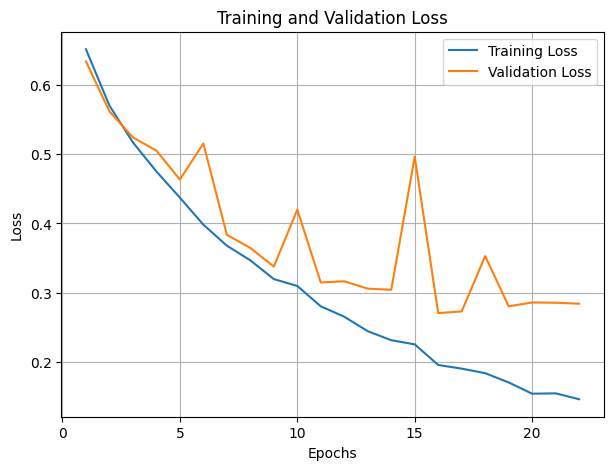

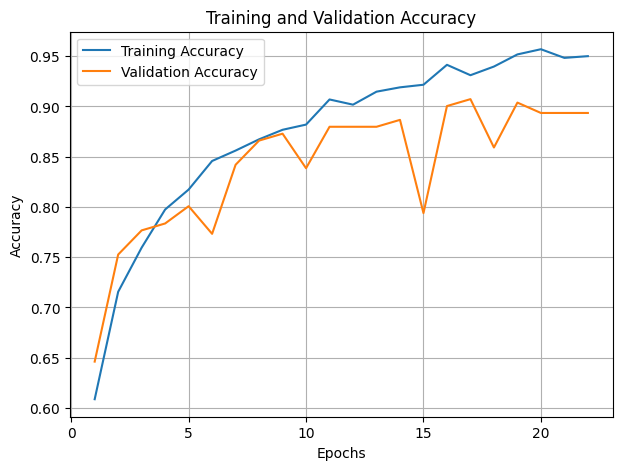

In [4]:
import matplotlib.pyplot as plt

# ================================
# 6. Plot Training and Validation Loss
# ================================
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

# ================================
# 7. Plot Training and Validation Accuracy
# ================================
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Training Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# Inference Code

In [5]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import efficientnet_b1
from PIL import Image, ImageEnhance
import numpy as np
import cv2

# Global variables to hold the model and device
_model = None
_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define Test-Time Augmentation (TTA) transforms
_tta_transforms = [
    transforms.Compose([
        transforms.Resize((640, 640)),  # Original scale (100%)
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.Resize((768, 768)),  # 120% scale
        transforms.CenterCrop((640, 640)),         # Crop back to 640x640
        transforms.ToTensor(),
    ]),
]

def get_class_name(image_path):
    """
    Predicts the class of an image given its file path.

    Args:
        image_path (str): The file path to the input image.

    Returns:
        str: The predicted class name ('non-box' or 'box').
    """
    global _model

    # Load the model only once
    if _model is None:

        _model = CNNModel().to("cuda")

        # Load the saved model weights
        try:
            _model.load_state_dict(torch.load('best_model_CNNScratch.pth', map_location=_device))
        except FileNotFoundError:
            raise FileNotFoundError("The model file 'best_model.pth' was not found.")
        except Exception as e:
            raise RuntimeError(f"An error occurred while loading the model: {e}")

        # Move the model to the appropriate device (GPU or CPU)
        _model.to(_device)

        # Set the model to evaluation mode
        _model.eval()


    try:
        # Open the image and convert to RGB
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        raise FileNotFoundError(f"The image file '{image_path}' was not found.")
    except Exception as e:
        raise RuntimeError(f"An error occurred while opening the image: {e}")

    # ========================
    # Prediction with TTA
    # ========================

    predictions = []

    # Apply each fixed-scale transformation for TTA
    for transform in _tta_transforms:
        # Apply the transformation
        input_tensor = transform(image)

        # Add batch dimension and move to device
        input_batch = input_tensor.unsqueeze(0).to(_device)

        # Perform inference without tracking gradients
        with torch.no_grad():
            output = _model(input_batch)

        # Convert output to probability using sigmoid
        probability = torch.sigmoid(output[0]).item()
        predictions.append(probability)

    # Calculate the average probability across all TTA scales
    avg_probability = sum(predictions) / len(predictions)

    # Define class labels
    classes = ['non-box', 'box']

    # Determine the class based on the average probability
    predicted_class = 1 if avg_probability >= 0.5 else 0
    # print(avg_probability)

    return predicted_class


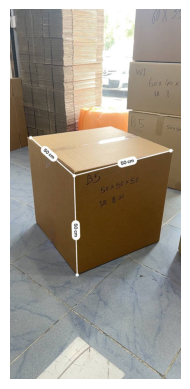

The predicted class is: box


In [10]:
import matplotlib.pyplot as plt
import cv2

classes = ['non-box', 'box']
image_path = "/content/1 (175).jpg"
result = get_class_name(image_path)

# Use cv2 to read and display the image
image = cv2.imread(image_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Turn off axis ticks and labels
plt.grid(False) # Turn off grid lines
plt.show()

print(f"The predicted class is: {classes[result]}")

# Evaluate Testset

100%|██████████| 100/100 [00:07<00:00, 14.06it/s]


Accuracy: 0.9000
Precision (class 0 - non-box): 0.9348, Precision (class 1 - box): 0.8704
Recall (class 0 - non-box): 0.8600, Recall (class 1 - box): 0.9400
F1-Score (class 0 - non-box): 0.8958, F1-Score (class 1 - box): 0.9038
Macro Precision: 0.9026, Macro Recall: 0.9000, Macro F1-Score: 0.8998


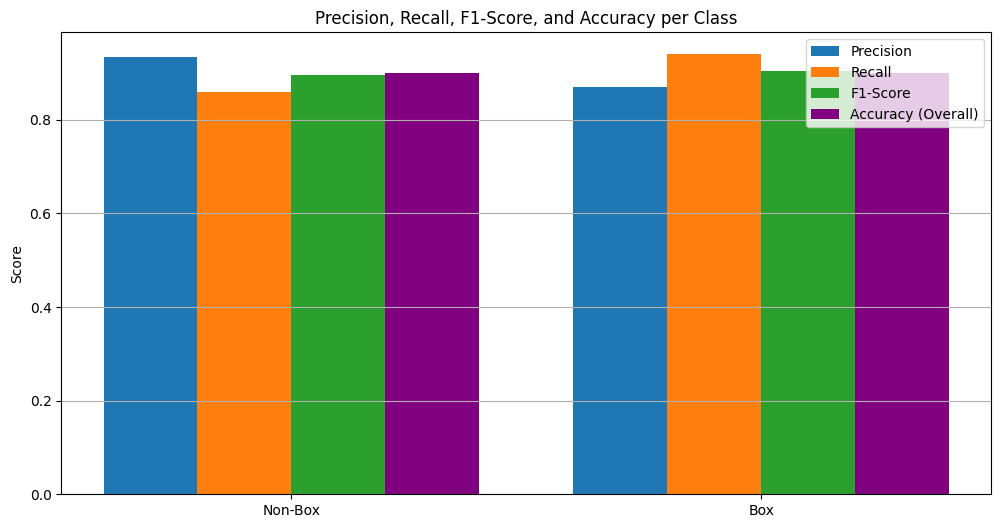

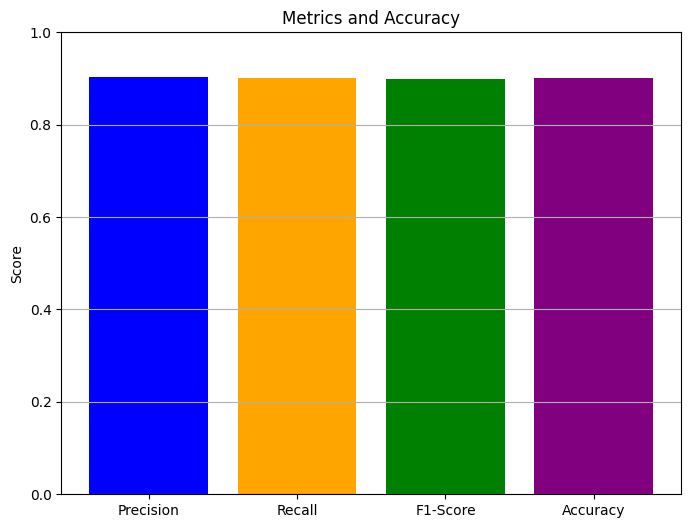

In [12]:
from glob import glob
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

total = 0
correct = 0

# Lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluate for 'xbox' (class 1)
for image_path in tqdm(glob("/content/drive/MyDrive/boxes_classification_test_2/boxes_classification_test_2/xbox/*")):
    result = get_class_name(image_path)
    true_labels.append(1)  # True label for 'xbox'
    predicted_labels.append(result)  # Predicted label
    total += 1
    correct += int(result == 1)

# Evaluate for 'non-box' (class 0)
for image_path in tqdm(glob("/content/drive/MyDrive/boxes_classification_test_2/boxes_classification_test_2/non-box/*")):
    result = get_class_name(image_path)
    true_labels.append(0)  # True label for 'non-box'
    predicted_labels.append(result)  # Predicted label
    total += 1
    correct += int(result == 0)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average=None)  # Per class precision
recall = recall_score(true_labels, predicted_labels, average=None)  # Per class recall
f1 = f1_score(true_labels, predicted_labels, average=None)  # Per class F1-score

# Macro averages
macro_precision = precision_score(true_labels, predicted_labels, average='macro')
macro_recall = recall_score(true_labels, predicted_labels, average='macro')
macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (class 0 - non-box): {precision[0]:.4f}, Precision (class 1 - box): {precision[1]:.4f}")
print(f"Recall (class 0 - non-box): {recall[0]:.4f}, Recall (class 1 - box): {recall[1]:.4f}")
print(f"F1-Score (class 0 - non-box): {f1[0]:.4f}, F1-Score (class 1 - box): {f1[1]:.4f}")
print(f"Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro F1-Score: {macro_f1:.4f}")

# ================================
# Plotting the Metrics
# ================================
# Data for plotting
classes = ['Non-Box', 'Box']
x = np.arange(len(classes))

# Plot Precision, Recall, F1-Score, and Accuracy for each class
plt.figure(figsize=(12, 6))
plt.bar(x - 0.3, precision, width=0.2, label='Precision', align='center')
plt.bar(x - 0.1, recall, width=0.2, label='Recall', align='center')
plt.bar(x + 0.1, f1, width=0.2, label='F1-Score', align='center')
plt.bar(x + 0.3, [accuracy, accuracy], width=0.2, label='Accuracy (Overall)', align='center', color='purple')
plt.xticks(x, classes)
plt.ylabel("Score")
plt.title("Precision, Recall, F1-Score, and Accuracy per Class")
plt.legend()
plt.grid(axis='y')
plt.show()

# Plot Averaged Metrics including Accuracy
metrics = ['Precision', 'Recall', 'F1-Score', 'Accuracy']
macro_scores = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(8, 6))
plt.bar(metrics, macro_scores, color=['blue', 'orange', 'green', 'purple'])
plt.ylabel("Score")
plt.title("Metrics and Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()